In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
import torch
import numpy as np
%matplotlib inline

In [3]:
from kernel_wasserstein_flows.gradient_flow import gradient_flow
from kernel_wasserstein_flows.kernels import gaussian_kernel
from kernel_wasserstein_flows.kale import kale_penalized, kale_penalized_first_variation

In [4]:
import logging

from kernel_wasserstein_flows.config import LOG_LEVELS
LOG_LEVELS['gradient_flow'] = logging.INFO

In [5]:
results = {}

In [6]:
from PIL import Image
def _load_img(fn='img/heart.png', size=200, max_samples=None):
    r"""Returns x,y of black pixels (between -1 and 1)
    """
    pic = np.array(Image.open(fn).resize((size,size)).convert('L'))
    y_inv, x = np.nonzero(pic<=128)
    y = size - y_inv - 1
    if max_samples and x.size > max_samples:
        ixsel = np.random.choice(x.size, max_samples, replace=False)
        x, y = x[ixsel], y[ixsel]
    return np.stack((x, y), 1) / size * 2 - 1

def _get_shapes_data():
    rs = np.random.RandomState(42)
    X = _load_img('img/spiral3d.jpg')
    X = X[rs.choice(len(X), 2000, replace=False)]

    Y = _load_img('img/heart.png')
    Y = Y[rs.choice(len(Y), 2000, replace=False)]

    Y = torch.from_numpy(Y).float()
    X = torch.from_numpy(X).float()
    Y.requires_grad = True
    return X, Y

# Shape transfer using KALE and MMD

In [7]:
_gf_default_kwargs = dict(
    # max_iter=100,
    random_seed=20,
    noise_level_callback=lambda x: 1e-20,
    num_noisy_averages=1,
    generator=_get_shapes_data,
    generator_kwargs=dict(),
    kernel=gaussian_kernel,
    kernel_kwargs={'sigma': 0.01},
    loss=kale_penalized,
    loss_first_variation=kale_penalized_first_variation
)

_kale_default_kwargs={
    "inner_max_iter": 800,
    "inner_tol": 1e-8,
    "inner_a": 0.4,
    "inner_b": 0.8,
    "inplace": False,
    "input_check":True,
    "dual_gap_tol": 5e-2,
    # "optimization_method":"newton",
    "optimization_method":"cd", "optimizer_kwargs": {"dual_gap_tol": 5e-2, "buffer_size": 1000, "max_iter": 20}, "online": True,
}

In [8]:
results = {}

In [9]:
import time 
from kernel_wasserstein_flows.kale import kale_penalized, kale_penalized_first_variation

for max_iter, lr, _lambda_, exp_name in zip([100, 100], [0.001, 1], [0.001, 10000], ['kale_0001', 'kale_10000']):
    # _lambda_ = 10000 amounts to MMD
    X, Y = _get_shapes_data()
    t0 = time.time()
    args, (X, Y), (trajectories, records, loss_states) = gradient_flow(max_iter=max_iter, lr=lr, loss_kwargs={"lambda_": _lambda_, **_kale_default_kwargs}, **_gf_default_kwargs)
    print(f'total time {time.time() - t0:.3f}s')
    results[exp_name] = {'args': args, 'X': X, 'Y': Y, 'trajectories': trajectories, 'records': records, 'loss_states': loss_states }

 gradient_flow: X.requires_grad: False, Y.requires_grad: True
 gradient_flow: loss: 2.27e+00 grad_norm: 3.26e+03
 kale.optim.online_cd: convergence was not reached after 19 iterations (dual gap: 0.011967122540264385, objective dual gap: 0.005)
 gradient_flow: loss: 3.89e-01 grad_norm: 1.30e+02
 gradient_flow: loss: 3.49e-01 grad_norm: 7.78e+01
 gradient_flow: loss: 3.26e-01 grad_norm: 6.68e+01
 gradient_flow: loss: 3.08e-01 grad_norm: 6.11e+01
 gradient_flow: loss: 2.91e-01 grad_norm: 5.75e+01
 gradient_flow: loss: 2.76e-01 grad_norm: 5.54e+01
 gradient_flow: loss: 2.62e-01 grad_norm: 5.34e+01
 gradient_flow: loss: 2.49e-01 grad_norm: 4.99e+01
 gradient_flow: loss: 2.37e-01 grad_norm: 4.80e+01
 gradient_flow: X.requires_grad: False, Y.requires_grad: True


total time 51.619s


 gradient_flow: loss: 7.13e-03 grad_norm: 3.87e+00
 gradient_flow: loss: 1.68e-03 grad_norm: 1.75e+00
 gradient_flow: loss: 8.50e-04 grad_norm: 1.39e+00
 gradient_flow: loss: 5.49e-04 grad_norm: 1.25e+00
 gradient_flow: loss: 4.27e-04 grad_norm: 1.24e+00
 gradient_flow: loss: 3.66e-04 grad_norm: 1.21e+00
 gradient_flow: loss: 3.19e-04 grad_norm: 1.20e+00
 gradient_flow: loss: 2.55e-04 grad_norm: 1.09e+00
 gradient_flow: loss: 2.62e-04 grad_norm: 1.12e+00
 gradient_flow: loss: 2.03e-04 grad_norm: 1.01e+00


total time 40.776s


In [13]:
# uncomment lines below in this cell to view an interactive visualisation of the computed flows
# from kernel_wasserstein_flows.plotting import vizualize_results
# from kernel_wasserstein_flows.utils import compute_velocity_field
# %matplotlib ipympl
# 
# exp_name = 'kale_0001'
# vs = compute_velocity_field(
#     X, trajectories,
#     results[exp_name]['args']['kernel'], results[exp_name]['args']['kernel_kwargs'], results[exp_name]['args']['loss'], results[exp_name]['args']['loss_kwargs'],
#     results[exp_name]['args']['loss_first_variation'], results[exp_name]['loss_states']
# )
# vizualize_results(results[exp_name]['X'], results[exp_name]['Y'], results[exp_name]['trajectories'], pd.json_normalize(results[exp_name]['records']), "MMD", metrics_subset=['loss'],
#                   velocities=vs)

# Shape transfer using the Sinkhorn Divergence

In [14]:
from geomloss import SamplesLoss

def sinkhorn_descent(Y, X, num_iter, lr):
    Y = Y.clone().detach()
    Y.requires_grad_(True)
    trajectories = [Y.clone()]
    sinkhorn_dist = SamplesLoss("sinkhorn", p=2, blur=0.05, diameter=4., backend= 'tensorized')
    for t in range(num_iter):
        loss = sinkhorn_dist(Y, X).sum()
        loss.backward()
        with torch.no_grad():
            Y = Y - lr * Y.grad
            Y.requires_grad = True
        
        if (t % max(num_iter // 20, 1)) == 0:
            print('loss: {:.4f}'.format(loss.item()))
        if (t % max(num_iter // 100, 1)) == 0:
            trajectories.append(Y.clone())

    return trajectories

In [15]:
X, Y = _get_shapes_data()
trajectories = sinkhorn_descent(Y, X, num_iter=100, lr=50)
results['sinkhorn'] = {'X': X.detach().numpy(), 'Y': Y.detach().numpy(), 'trajectories': torch.stack(trajectories, axis=0).detach().numpy()}

loss: 0.0517
loss: 0.0394
loss: 0.0301
loss: 0.0231
loss: 0.0177
loss: 0.0136
loss: 0.0105
loss: 0.0081
loss: 0.0063
loss: 0.0050
loss: 0.0039
loss: 0.0031
loss: 0.0025
loss: 0.0021
loss: 0.0017
loss: 0.0015
loss: 0.0013
loss: 0.0011
loss: 0.0010
loss: 0.0009


In [17]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'target')

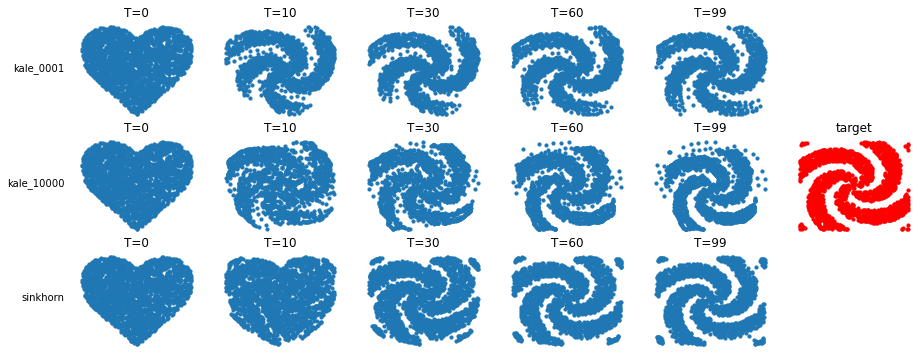

In [20]:
iter_nos = [0, 10, 30, 60, 99]
# iter_nos = [0, -1, -1, -1]
f, axs = plt.subplots(nrows=len(results), ncols=len(iter_nos)+1, figsize=(5 * len(results), len(iter_nos)+1))

for (loss_name, result), axs_row in zip(results.items(), axs):
    for ax, iter_no in zip(axs_row, iter_nos):
        if iter_no == 0:
            ax.scatter(Y.detach().numpy()[:, 0], Y.detach().numpy()[:, 1], s=10)
        else:
            ax.scatter(result['trajectories'][iter_no][:, 0], result['trajectories'][iter_no][:, 1], s=10)
        ax.axis('off')
        ax.set_title(f'T={iter_no}')
    axs_row[0].text(x=-0.1, y=0.5, s=loss_name, transform=axs_row[0].transAxes, horizontalalignment='right')
    axs_row[-1].axis('off')
    
axs[len(axs) // 2][-1].scatter(result['X'][:, 0], result['X'][:, 1], s=10, color='red')
axs[len(axs) // 2][-1].set_title('target')